# Disease-Chemical Co-Occurrence Matrix

To better understand what drugs are currently tested against COVID-19, I create a co-occurrence matrix based on the mentions of diseases and drugs, specifically antivirals.

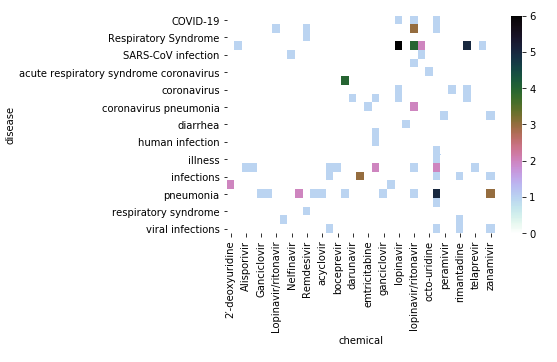

**Pipeline:**
1. Extract abstracts from metadata.csv
2. Disease-Chemical Named Entity Recognition from abstracts. Model: SciBert, ner_bc5cdr_md
    * Find Disease-Chemical pairs that occur on the sentence level.
4. Find diseases associated with "SARS-CoV-2"
5. Find chemicals associated with the above diseases 
6. Produce a co-occurrence matrix
7. Generate a heatmap to visualize the matrix

# Importing Libraries

In [ ]:
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz
!pip install MulticoreTSNE

import scispacy
import en_ner_bc5cdr_md

#Faster T-SNE implementation
from MulticoreTSNE import MulticoreTSNE as TSNE

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import matplotlib.pyplot as plt

import spacy
from spacy import displacy
from collections import Counter
import pickle
from collections import defaultdict

import seaborn as sns # plotting

%matplotlib inline

In [ ]:
metadata = pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv")
metadata = metadata.fillna("")

# Loading SciBert bc5cdr NER Model

In [ ]:
nlp = en_ner_bc5cdr_md.load()

# Find disease-chemical pairs that occur on the sentence level.
This process takes about 25 minutes for me. I save the results for future use in the next cell.

In [ ]:
dc_vocab = []
d2c_pairs = []

for row in tqdm(metadata.iterrows()):
    doc = nlp(row[1]["abstract"])
    dc_vocab.extend(doc.ents)
                
    for sent in doc.sents:
        for i in sent.ents:
            if i.label_ == "DISEASE":
                for j in sent.ents:
                    if j.label_ == "CHEMICAL":
                        d2c_pairs.append(((i.text, i.label_), (j.text, j.label_)))

In [ ]:
pickle.dump([a.as_doc() for a in dc_vocab], open("docs.pk", "wb"))
pickle.dump(d2c_pairs, open("d2c_pairs.pk", "wb"))

In [ ]:
# UNPACKING
# dc_vocab = pickle.load(open("/kaggle/input/cord-19/docs.pk", "rb"))
# dc_vocab = [a.ents[0] for a in dc_vocab]

# d2c_pairs = pickle.load(open("/kaggle/input/d2c-pairs/d2c_pairs.pk", "rb"))

In [ ]:
diseases = [a for a in dc_vocab if a.label_ == "DISEASE"]
common_diseases = [a[0] for a in Counter([a.text for a in diseases]).most_common()[:300]]
print(common_diseases)

disease_set = set()
mini_batch = []

for a in dc_vocab:
    if a.text in common_diseases and a.text not in disease_set:
        mini_batch.append(a)
        disease_set.add(a.text)

# Importing Drug Name Stems

In [ ]:
nomenclature = pd.read_csv("/kaggle/input/drug-namestems/drug_nomenclature (1).csv")
nomenclature.drop(columns=['web-scraper-order', 'web-scraper-start-url'])
drug_namestems = list(nomenclature["affix_suffix"])

In [ ]:
#Helper Function. It matches a string with a stem. 

def dstem_match(sstr, stem):
    pruned = stem.replace("-", "")
    stem_len = len(pruned)
    
    if stem[0] == "-" and stem[-1] != "-":
        if sstr[-stem_len:] == pruned:
            return True
    elif stem[-1] == "-" and stem[0] != "-":
        if sstr[:stem_len] == pruned:
            return True
    else:
        if pruned in sstr:
            return True
    
    return False

# Find diseases associated with "SARS-CoV-2"

In [ ]:
key_list = [a[0][0][0] for a in list(Counter([a for a in d2c_pairs if a[1][0] == "SARS-CoV-2"]).most_common())]

# Find chemicals associated with the above diseases

In [ ]:
relevant_pairs = [a for a in d2c_pairs if a[0][0] in key_list] 

### Filter antivirals from chemicals
Using other drug name stems gets a bit messy, so I'm using the common stem, -vir, for antiviral drugs for now.

In [ ]:
filtered = []

for pair in relevant_pairs:
    if dstem_match(pair[1][0], "-vir"):
        filtered.append(pair)
            
filtered

# Produce a co-occurrence matrix of disease and antivirals

In [ ]:
items = [(i[0][0], i[1][0]) for i in filtered]
dc_df = pd.DataFrame(items, columns =['disease', 'chemical']) 
cmatrix = pd.crosstab(dc_df.disease, dc_df.chemical)

cmatrix

# Generate a heatmap to visualize the matrix

In [ ]:
sns.heatmap(cmatrix, cmap=plt.cm.cubehelix_r)

# Disease Vector Dimensionality Reduction with t-SNE

In [ ]:
disease_groups = list(set([a[0][0] for a in filtered]))
len(disease_groups)

In [ ]:
added = set()
mini_batch = []

for a in dc_vocab:
    if a.text in disease_groups and a.text not in added:
        added.add(a.text)
        mini_batch.append(a)
        
annotations = [a.text for a in mini_batch]

X_embedded = TSNE(n_components=2, verbose=1).fit_transform(np.array([a.vector for a in mini_batch]))
X_embedded.shape

# kmeans = KMeans(n_clusters=10, random_state=5, verbose=1).fit(X_embedded)

plt.figure(figsize=(10,10))
cdict = {1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'purple'}
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

for i, txt in enumerate(annotations):
    plt.annotate(txt, (X_embedded[:, 0][i], X_embedded[:, 1][i]))

plt.show()